# **Nadgledano učenje - Klasifikacija kvaliteta belog vina**
**Studenti**: 
 - Natalija Stamenković, 1258
 - Milica Todorović, 1256

**Tema**: Određivanje kvaliteta belog vina na osnovu fizičko-hemijskih karakteristika. Korišćeni skup podataka može se naći na linku: https://archive.ics.uci.edu/ml/datasets/wine+quality.


### ***Deskriptivna analiza podataka***
#### *Importovanje paketa*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
%matplotlib inline

#### *Učitavanje skupa podataka*
U tabeli se mogu videti vrednosti atributa datog skupa podataka. Svi atributi su numeričkog kontinualnog tipa. Klasifikaciju je potrebno izvršiti na osnovu poslednje kolone (*quality*), pri čemu zavisna promenljiva uzima celobrojne vrednosti iz intervala [0,9].

In [46]:
data = pd.read_csv("./dataset/winequality-white.csv", delimiter=';')
data.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.001,3.0,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.994,3.3,0.49,9.5,6


#### *Deskripcija atributa*
Sledeća tabela prikazuje statističke informacije o atributima (srednju vrednost, standardnu devijaciju, min, max itd.) Za dodatne informacije o atributima prikazana je vrednost medijana svakog atributa.

In [3]:
print("Describe data:")
data.describe(include='all')

Describe data:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [4]:
print("Median:")
data.median()

Median:


fixed acidity             6.80000
volatile acidity          0.26000
citric acid               0.32000
residual sugar            5.20000
chlorides                 0.04300
free sulfur dioxide      34.00000
total sulfur dioxide    134.00000
density                   0.99374
pH                        3.18000
sulphates                 0.47000
alcohol                  10.40000
quality                   6.00000
dtype: float64

#### *Provera nedefinisanih vrednosti*
Vrši se provera da li postoje atributi koji sadrže određene *missing* vrednosti (vrednosti koje fale). Pokazuje se da podaci ne sadrže nedefinisane vrednosti.

In [5]:
def check_missing_vals(data):
    missing_vals = data.isna().sum()
    print(missing_vals)
    return missing_vals.sum() != 0

print("Missing values?:", check_missing_vals(data))

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Missing values?: False


#### *Histogram quality atributa*
Na sledećem grafiku prikazan je histogram atributa kvaliteta vina. Može se videti izrazit disbalans među klasama kvaliteta, pri čemu najveći broj vina ima ocenu u intervalu [5,7].

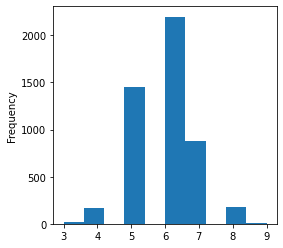

In [47]:
def plot_histogram(data, data_column):
    data[data_column].plot(kind='hist', figsize=(4, 4))
    
plot_histogram(data=data, data_column='quality')

#### *Boxplot atributa*
Sledeći grafik prikazuje boxplot dijagram za svaki od atributa. Može se uočiti veliki broj outlier-a u vrednostima atributa *volatile acidity*, *citric acid*, *chlorides*, *sulphates*, *pH* i *free sulfur dioxide*.

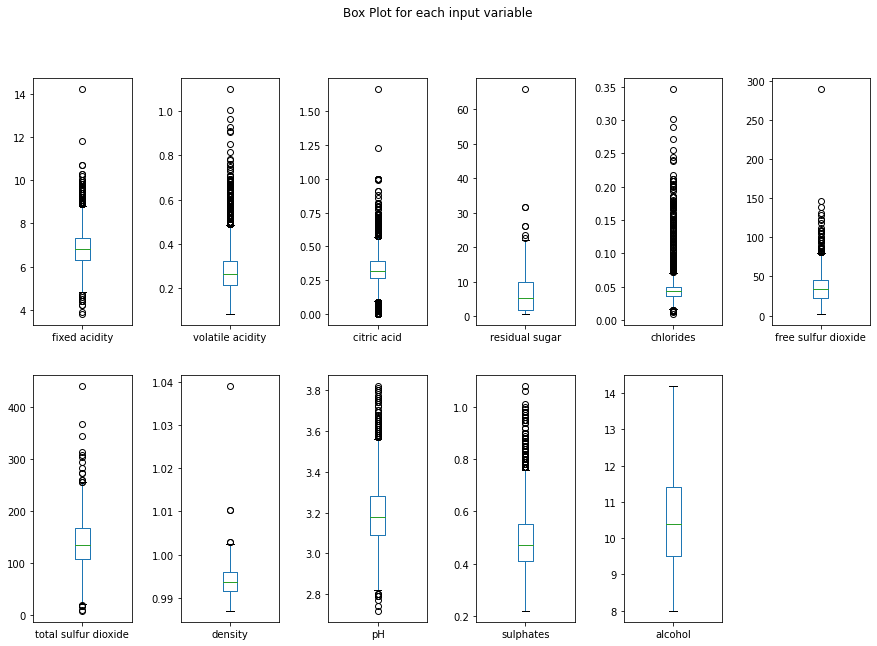

In [7]:
def plot_boxplot(data):
    data.drop('quality', axis=1).plot(kind='box', figsize=(15, 10), subplots=True, layout=(2, 6),
                                      sharex=False, sharey=False,
                                      title='Box Plot for each input variable')
    plt.subplots_adjust(wspace=0.5)
    
plot_boxplot(data)

#### *Raspodela vrednosti atributa po klasama*
Može se vizualizovati raspodela vrednosti atributa po klasama. Može se primetiti da određenim atributima vrednosti ne variraju u odnosnu na klasu kvaliteta, te je možda moguće date atribute isključiti iz dalje analize.

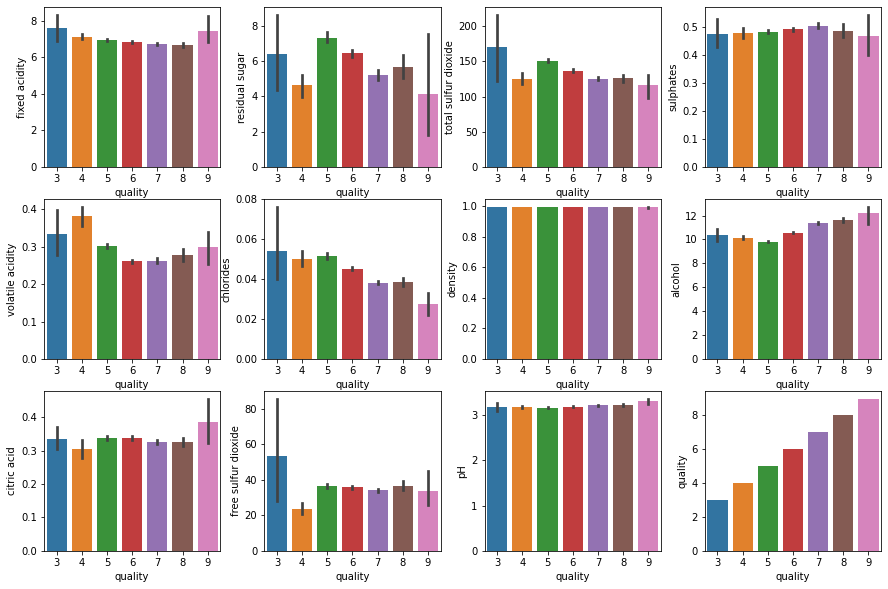

In [8]:
def plot_barplots(data):
    num_rows = 3
    num_cols = 4
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i in range(0, num_rows):
        for j in range(0, num_cols):
            index = j * num_rows + i
            col_name = data.columns[index]
            sns.barplot(x='quality', y=col_name, data=data, ax=axs[i][j])
            
    plt.subplots_adjust(wspace=.25)

plot_barplots(data)

#### *Matrica korelacije*
Dijagram prikazuje matricu korelacije fičera. Takođe, se štampaju fičeri sortirani po koeficijentu korelacije u opadajućem poredku, u odnosu na zavisnu klasifikacionu promenljivu.
Može se uočiti da atribut *alcohol* ima najveći stepen korelacije sa atributom *quality*. Takođe, mogu se uočiti međusobne korelacije između atributa (atribut *density* je visoko korelisan sa većim brojem atributa).

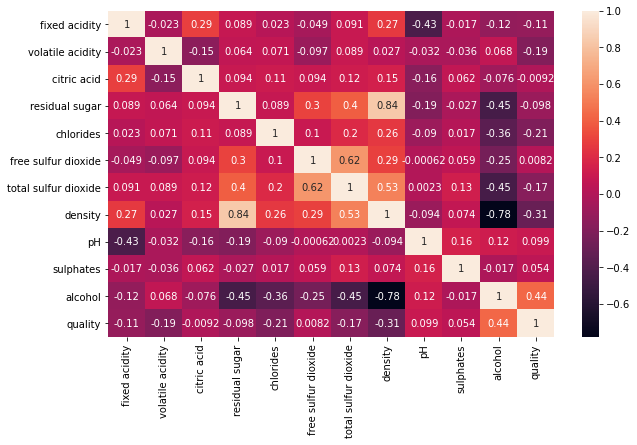

Sorted correlation values: 
 quality                 1.000000
alcohol                 0.435575
density                 0.307123
chlorides               0.209934
volatile acidity        0.194723
total sulfur dioxide    0.174737
fixed acidity           0.113663
pH                      0.099427
residual sugar          0.097577
sulphates               0.053678
citric acid             0.009209
free sulfur dioxide     0.008158
Name: quality, dtype: float64


In [9]:
def correlation_matrix(data):
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax)
    plt.show()

    corr = abs(corr['quality']).sort_values(ascending=False)
    return corr

corr = correlation_matrix(data)
print("Sorted correlation values: \n", corr)

### *Predefinisanje klasa*
Kao što je prethodno pokazano klase kvaliteta su izuzetno nebalansirane, te je pokušano predefinisanje klasa kako bi se disbalans ublažio. Kvalitet vina podeljen je u 3 nove klase:
- bad: [1, 4]
- good: [5, 6]
- excellent: [7, 10].

Skup podataka je još uvek nebalansiran, ali je disbalans ublažen.

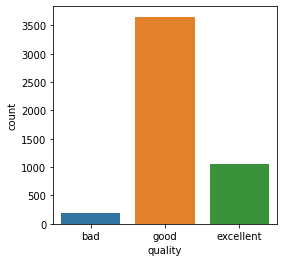

In [10]:
def redefine_classes(data):
    bins = (0, 4, 6, 10)
    labels = ['bad', 'good', 'excellent']
    redef_data = data.copy(deep=True)
    redef_data['quality'] = pd.cut(data['quality'], bins=bins, labels=labels)
    return redef_data

def plot_count(data, data_column):
    plt.figure(figsize=(4, 4))
    sns.countplot(x=data_column, data=data)

plot_count(redefine_classes(data), 'quality')

### ***Preprocesiranje podataka***
Preprocesiranje podataka uključuje prethodno opisano predefinisanje klasa. Kako je sada atribut *quality* kategoričkog tipa, potrebno je izvršiti enkodiranje datih klasa u numerični tip. Ovo se postiže korišćenjem LabelEncode-era.

In [11]:
def encode_labels(data):
    encode_quality = LabelEncoder()
    data['quality'] = encode_quality.fit_transform(data['quality'])
    return data

Dalje, potrebno je podeliti dati skup podataka na nezavisne promenljive (atribute - x) i zavisnu promenljivu (*quality* - y). Poslednja kolona predstavlja zavisnu promenljivu, dok ostale kolone predstavljaju fičere.

In [12]:
def extract_data(data):
    x = data.iloc[:, :-1].values
    # dependent variable
    y = data.iloc[:, -1].values
    return x, y

Nakon toga, vrši se podela skupa podataka na trening i test skupove, pri čemu je za trening skup uzeto 20% celokupnog skupa.

In [13]:
def split_dataset(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

Finalno, vrši se skaliranje vrednosti korišćenjem StandardScaler-a. Skaliranje se vrši zasebno na trening i test skupovima podataka, s obzirom da je potrebno tretirani test skup podataka kao podatke koji nisu prethodno "viđeni".

In [14]:
def scale_features(x_train, x_test):
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)
    return x_train, x_test

Celokupno preprocesiranje:

In [49]:
data = redefine_classes(data)
data = encode_labels(data)

x, y = extract_data(data)
x_train, x_test, y_train, y_test = split_dataset(x, y)

x_train_s, x_test_s = scale_features(x_train, x_test)

In [50]:
df_train = pd.DataFrame(x_train_s)
df_train['quality'] = y_train
df_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,quality
0,0.515119,-1.076233,0.227731,0.340419,-0.813688,0.534065,-0.641932,-0.447041,-0.328261,-0.702445,1.540371,2
1,-0.669188,-0.288777,0.895832,1.002071,-0.217212,0.773947,1.355106,0.903370,-0.061886,0.266074,-0.821712,2


### ***Klasifikatori***

U nastavku su date pomoćne funkcije koje se koriste pri evaluaciji svakog modela/klasifikatora, određivanje matrice konfuzije i skora unakrsne validacije. Celokupna evaluacija modela sastoji se od: skora unakrsne validacije, preciznosti modela, izveštaja klasifikacije i matrice konfuzije.

In [17]:
def confusion_matrix(y_test, y_pred, plot=False):
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    if plot:
        df_conf = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
        sns.heatmap(df_conf, annot=True, fmt='g')
        plt.title("Confusion matrix:")
        plt.xlabel("False")
        plt.ylabel("True")
    else:
        print("Confusion matrix:\n", conf_matrix)
        

def cross_val_eval(estimator, x_train, y_train):
    cv_eval = cross_val_score(estimator=estimator, X=x_train, y=y_train, cv=5, scoring="accuracy")
    print("Cross validation - Accuracy:\n", cv_eval.mean())

In [18]:
# function for evaluating a model
def evaluate_model(estimator, x_train, y_train, y_test, y_pred, plot_conf=False):
    cross_val_eval(estimator, x_train, y_train)
    print("Accuracy:\n", metrics.accuracy_score(y_test, y_pred))
    print("Report:\n", metrics.classification_report(y_test, y_pred))
    confusion_matrix(y_test, y_pred, plot_conf)

In [19]:
# names of quality classes
class_names = [0, 1, 2]

Dalje, data je metoda kojom se vrši dabir najboljih hiperparametara klasifikatora korišćenjem GridSearchCV objekta.

In [20]:
# metod used to search for best hiperparameters for a given classifier
def grid_search(classifier, param_dict,
               x_train, y_train):
    gs = GridSearchCV(estimator=classifier, param_grid=param_dict, scoring="accuracy",
                          refit=True, cv=5, verbose=True, n_jobs=-1)
    gs.fit(x_train, y_train)

    print("Best estimator:\n", gs.best_params_)
    print("Best score: ", gs.best_score_)

    return gs.best_estimator_

Funkcija kojom se pokreće svaki klasifikator i štampa evaluacija datog modela.

In [21]:
def run_clf(clf, param_dict,
            x_train, x_test, y_train, y_test, plot_conf=False,
            is_grid_search=False):
    
    if is_grid_search:
        clf = grid_search(clf, param_dict,
                         x_train, y_train)
    else:
        # Train the algorithm
        clf.fit(x_train, y_train)
    
    # predict
    y_pred = clf.predict(x_test)
    #

    # evaluate
    evaluate_model(clf, x_train, y_train, y_test, y_pred, plot_conf)

#### *k-NN*
Prvi razmatrani klasifikator je k-NN. Mogući parametri klasifikacija korišćeni u okviru GridSearch-a dati su u okviru dictionary-a. Klasifikator ne daje loše rezultate kada je u pitanju 2. klasa, međutim daje izuzetno loše rezultate za 0. i 1. klasu.

In [22]:
# knn classifier
clf_knn = KNeighborsClassifier()
# grid search params
param_dict_knn = [{'n_neighbors': [3, 5, 11, 19, 23],
               'metric': ['euclidean', 'manhattan'],
               'weights': ['uniform', 'distance']}]

run_clf(clf_knn, param_dict_knn, x_train_s, x_test_s, y_train, y_test, is_grid_search=True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished


Best estimator:
 {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Best score:  0.830524930278625
Cross validation - Accuracy:
 0.830524930278625
Accuracy:
 0.8316326530612245
Report:
               precision    recall  f1-score   support

           0       1.00      0.03      0.06        30
           1       0.77      0.56      0.65       227
           2       0.84      0.95      0.89       723

    accuracy                           0.83       980
   macro avg       0.87      0.51      0.54       980
weighted avg       0.83      0.83      0.81       980

Confusion matrix:
 [[  1   1  28]
 [  0 127 100]
 [  0  36 687]]


#### *Support Vector Machine - SVM*
Dalji razmatrani klasifikator je SVM. Rezultati SVM klasifikatora čine se gorim od k-NN.

In [23]:
# classifier
clf_svm = svm.SVC()
param_dict_svm = [{'kernel': ['rbf'],
               'gamma': [1e-3, 1e-4],
               'C': [1, 10, 100, 1000]}]
# run classifier
run_clf(clf_svm, param_dict_svm, x_train_s, x_test_s, y_train, y_test, is_grid_search=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.1s finished


Best estimator:
 {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Best score:  0.7812654755388746
Cross validation - Accuracy:
 0.7812654755388746
Accuracy:
 0.7765306122448979
Report:
               precision    recall  f1-score   support

           0       0.50      0.03      0.06        30
           1       0.70      0.29      0.41       227
           2       0.79      0.96      0.86       723

    accuracy                           0.78       980
   macro avg       0.66      0.43      0.45       980
weighted avg       0.76      0.78      0.73       980

Confusion matrix:
 [[  1   0  29]
 [  0  66 161]
 [  1  28 694]]


#### *Random Forest*
Random Forest klasifikator pati od istog problema klasifikacije klasa sa manjim brojem instanci kao i prethodno razmatrani klasifikatori, ali se pokazuje kao trenutno najuspešniji.

In [24]:
# random forest classifier
clf_rf = RandomForestClassifier()
# grid search params
param_dict_rf = {
    "n_estimators": [50, 100, 150, 200, 250],
    "min_samples_leaf": range(1, 5),
    "criterion": ['gini', 'entropy'],
    "class_weight": ["balanced", None, "balanced_subsample"]
}

run_clf(clf_rf, param_dict_rf, x_train_s, x_test_s, y_train, y_test, is_grid_search=True)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.4min finished


Best estimator:
 {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_leaf': 2, 'n_estimators': 150}
Best score:  0.8397099069512862
Cross validation - Accuracy:
 0.8363939062214925
Accuracy:
 0.8479591836734693
Report:
               precision    recall  f1-score   support

           0       0.57      0.13      0.22        30
           1       0.80      0.63      0.71       227
           2       0.86      0.94      0.90       723

    accuracy                           0.85       980
   macro avg       0.74      0.57      0.61       980
weighted avg       0.84      0.85      0.84       980

Confusion matrix:
 [[  4   0  26]
 [  0 144  83]
 [  3  37 683]]


#### *Gradient boosting*
Pokušano je poboljšavanje rezultata korišćenjem gradient boosting klasifikatora. Rezultati su relativno slični onima dobijenim korišćenjem Random Forest-a.

In [25]:
# classifier
clf_gb = GradientBoostingClassifier()
param_dict_gb = {
    "n_estimators": [50, 100, 150, 200, 250],
    "criterion": ["friedman_mse", "mse"],
    "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
    "max_depth": range(3, 6)
}


run_clf(clf_gb, param_dict_gb, x_train_s, x_test_s, y_train, y_test, is_grid_search=True)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 19.8min finished


Best estimator:
 {'criterion': 'friedman_mse', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}
Best score:  0.8315437094377982
Cross validation - Accuracy:
 0.8289904084239058
Accuracy:
 0.8255102040816327
Report:
               precision    recall  f1-score   support

           0       0.43      0.33      0.38        30
           1       0.74      0.61      0.67       227
           2       0.86      0.91      0.89       723

    accuracy                           0.83       980
   macro avg       0.68      0.62      0.64       980
weighted avg       0.82      0.83      0.82       980

Confusion matrix:
 [[ 10   0  20]
 [  0 139  88]
 [ 13  50 660]]


***Zaključak nakon testiranja gorenavedenih klasifikatora je da Random Forest klasifikator daje najbolje rezultate.***

### ***Balansiranje podataka i izbacivanje outlier-a***
Prethodno je pokazano da prikazani klasifikatori ne daju previše loše rezultate kada je u pitanju klasa sa velikim brojem instanci. Međutim, matrica konfuzije, kao i pojedinačni f1-score za svaku klasu pokazuju da se svi klasifikatori ponašaju relativno loše kada su u pitanju nulta i prva klasa. Kao što je prethodno pokazano klase kvaliteta vina nisu balansirane, te to može biti jedan od potencijalnih uzroka ovog problema. Pokušaj otklanjanja ovog problema uključuje izbacivanje outlier-a i pokušaj oversample-ovanja manjinskih klasa.

#### *Izbacivanje outlier-a*
Smanjenje outlier-a svodi se na dve metode: smanjenje uticaja ekstemnih vrednosti (logaritmovanjem svih vrednosti datog fičera) i promena vrednosti outlier-a na gornju ili donju granicu datu IQR-om. 

In [26]:
# replace the outlier with the upper or lower bound 
# based on the IQR
def replace_outliers_bound(feature):
    q1, q3 = np.percentile(feature, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    new_feature = feature
    new_feature = np.where(new_feature > upper_bound, upper_bound, new_feature)
    new_feature = np.where(new_feature < lower_bound, lower_bound, new_feature)
    return new_feature

# replace all values of a feature with log(feature)
def replace_outliers_log(feature):
    return np.log(feature)

Outlier-i fičera čije su vrednosti u intervalu [0, 1] zamenjuju se gornjom ili donjom granicom tog fičera, dok se ostalim outlier-ima smanjuje uticaj korišćenjem logaritma.

In [27]:
def handle_outliers(x):
    all_indices = list(range(0, x.shape[1]))
    new_x = np.copy(x)
    """
        fixed acidity, sugar
        free sul. dioxide, total sul. dioxide
    """
   
    log_indices = [0, 3, 5, 6]
    for ind in log_indices:
        new_feature = replace_outliers_log(new_x[:, ind])
        new_x[:, ind] = new_feature

    bound_indices = np.setdiff1d(all_indices, log_indices)
    for ind in bound_indices:
        new_feature = replace_outliers_bound(new_x[:, ind])
        new_x[:, ind] = new_feature

    return new_x

Kao i prethodno, potrebno je zasebno pokrenuti funkciju za trening i test podatke. Smanjenje outlier-a se izvršava pre operacije skaliranja, tako da je potrebno skalirati novodobijene vrednosti. Iz opisa podataka može se videti da je broj uticaj outlier-a smanjen.

In [28]:
# handle outliers in x_train and x_test
x_train_out = handle_outliers(x_train)
x_test_out = handle_outliers(x_test)

df_train_outliers = pd.DataFrame(x_train_out)

# preform scale again
x_train_out, x_test_out = scale_features(x_train_out, x_test_out)

df_train_outliers.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000
mean,1.919022,0.275947,0.328335,1.487502,0.043529,3.427902,4.875782,0.994058,3.188102,0.487805,10.508840
std,0.121587,0.089625,0.099685,0.925590,0.011260,0.551048,0.335999,0.002922,0.146186,0.107423,1.227887
min,1.335001,0.080000,0.105000,-0.510826,0.015000,1.098612,2.302585,0.987110,2.805000,0.220000,8.000000
25%,1.840550,0.210000,0.270000,0.530628,0.036000,3.135494,4.682131,0.991740,3.090000,0.410000,9.500000
50%,1.916923,0.260000,0.320000,1.648659,0.043000,3.496508,4.897840,0.993800,3.180000,0.470000,10.400000
75%,1.987874,0.330000,0.380000,2.302585,0.050000,3.828641,5.117994,0.996200,3.280000,0.550000,11.400000
max,2.468100,0.510000,0.545000,4.186620,0.071000,4.987025,5.746203,1.002890,3.565000,0.760000,14.200000


#### *Balansiranje podataka*
Za metodu balansiranja klasa pokušano je korišćenje oversampling tehnike, odnosno SMOTE (Synthetic Minority Oversampling Technique). Nova raspodela klasa može se videti na dijagramu ispod.

In [29]:
def smote_data(x_train, y_train):
    smote = SMOTE()
    x_train, y_train = smote.fit_resample(x_train, y_train)
    return x_train, y_train

"""
x_train_smt -> smote x_train_out
y_train_smt -> smote y_train
x_test_out -> remove outliers x_test
y_test_out -> y_test renamed
"""
x_train_smt, y_train_smt = smote_data(x_train_out, y_train)
y_test_out = y_test

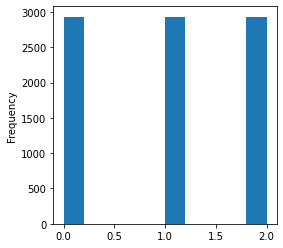

In [30]:
df_y_smt = pd.DataFrame(y_train_smt, columns=['quality'])
plot_histogram(data=df_y_smt, data_column='quality')

Kako se Random Forest klasifikator dosada pokazao kao najefikasniji, on će biti testiran sa balansiranim podacima. Ponašanje klasifikatora se poboljšalo za klase koje su prethodne bile u manjini, ali se za nijansu pogoršalo za dominantnu klasu. Odlučeno je da će se na dalje raditi sa balansiranim podacima.

In [31]:
run_clf(clf_rf, param_dict_rf, x_train_smt, x_test_out, y_train_smt, y_test_out, is_grid_search=True)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 13.3min finished


Best estimator:
 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 250}
Best score:  0.9290598997364204
Cross validation - Accuracy:
 0.9262176985890743
Accuracy:
 0.810204081632653
Report:
               precision    recall  f1-score   support

           0       0.27      0.53      0.36        30
           1       0.68      0.78      0.73       227
           2       0.91      0.83      0.87       723

    accuracy                           0.81       980
   macro avg       0.62      0.71      0.65       980
weighted avg       0.84      0.81      0.82       980

Confusion matrix:
 [[ 16   0  14]
 [  4 177  46]
 [ 40  82 601]]


### ***Selekcija fičera***
Smanjenje dimenzionalnosti pokušano je kao sledeća metoda u nadi poboljšanja datih modela. Za selekciju fičera korišćena su dva algoritma: Principal Component Analysis (PCA) i Recursive Feature Elimination (RFE).
#### *PCA*

In [32]:
# run pca with fixed number of features
# and print variance
def pca_selection(x_train, x_test, num_features):
    pca = PCA(n_components=num_features, random_state=200, whiten=True)
    pca.fit(x_train)

    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)

    var_ratio = pca.explained_variance_ratio_*100
    print("Variance ratio - PCA\n", var_ratio)
    print("Total variance - PCA: ", np.sum(var_ratio))

    return x_train, x_test, var_ratio

def plot_pca(variance):
    plt.plot(variance)
    plt.xlabel('Number of components')
    plt.ylabel("Variance")

Prvo će biti pokrenuta PCA selekcija sa svim fičerima, ne bi li se utvrdio odgovarajući broj principalnih komponenti. Može se zaključiti da zadržavanje 8-9 komponenti zadržava zadovoljavajuću količinu varijanse.

Variance ratio - PCA
 [29.9438639  16.06116946 14.65300782  9.17917644  8.30791603  6.4014237
  5.44794683  4.09748345  2.84289701  2.80278204  0.2623333 ]
Total variance - PCA:  100.0


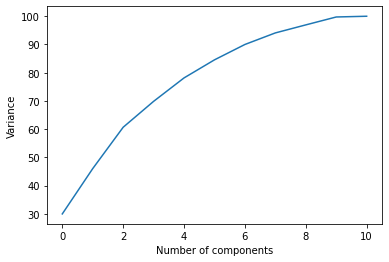

In [33]:
x_train_pca, x_test_pca, var_ratio = pca_selection(x_train_smt, x_test_out, x_train_smt.shape[1])
plot_pca(np.cumsum(var_ratio))

In [34]:
x_train_pca, x_test_pca, var_ratio = pca_selection(x_train_smt, x_test_out, 9)

"""
rename
y_test_pca
y_train_pca
"""

y_test_pca = y_test_out
y_train_pca = y_train_smt

Variance ratio - PCA
 [29.9438639  16.06116946 14.65300782  9.17917644  8.30791603  6.4014237
  5.44794683  4.09748345  2.84289701]
Total variance - PCA:  96.93488465563533


#### *k-NN - PCA*
Pokazuje se da je korišćenje PCA i balansiranje klasa znatno poboljšalo k-NN klasifikator.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.1s finished


Best estimator:
 {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best score:  0.9049578143573311
Cross validation - Accuracy:
 0.9049578143573311
Accuracy:
 0.7510204081632653
Report:
               precision    recall  f1-score   support

           0       0.20      0.60      0.31        30
           1       0.60      0.79      0.68       227
           2       0.91      0.75      0.82       723

    accuracy                           0.75       980
   macro avg       0.57      0.71      0.60       980
weighted avg       0.82      0.75      0.77       980



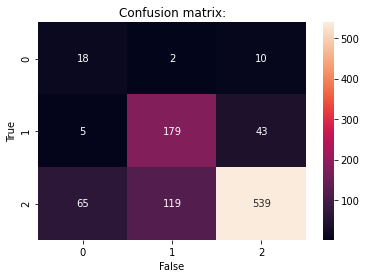

In [36]:
run_clf(clf_knn, param_dict_knn, x_train_pca, x_test_pca, y_train_pca, y_test_pca,
        is_grid_search=True, plot_conf=True)

#### *SVM - PCA*
Kombinacija PCA i balansiranja klasa je negativno uticala na klasifikciju dominantne klase SVM klasifikatora, dok su se rezultati u druge 2 klase zanemarljivo popravili.

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   36.8s finished


Best estimator:
 {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Best score:  0.7087325572381002
Cross validation - Accuracy:
 0.7087325572381002
Accuracy:
 0.6081632653061224
Report:
               precision    recall  f1-score   support

           0       0.12      0.63      0.20        30
           1       0.48      0.74      0.58       227
           2       0.87      0.57      0.69       723

    accuracy                           0.61       980
   macro avg       0.49      0.65      0.49       980
weighted avg       0.76      0.61      0.65       980



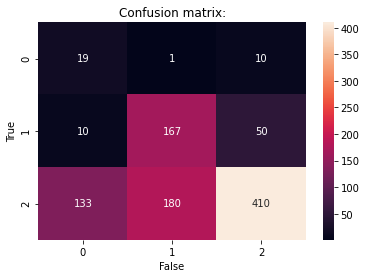

In [37]:
# run classifier
run_clf(clf_svm, param_dict_svm, x_train_pca, x_test_pca, y_train_pca, y_test_pca, 
        is_grid_search=True, plot_conf=True)

#### *Random forest - RFE*
Random forest svakom fičeru dodeljuje koeficijent važnosti, te se svi fičeri mogu sortirati po važnosti.

In [38]:
def plot_feature_importance(fitted_model, data):
    """
    plot feature importance
    """
    feature_importance = fitted_model.feature_importances_
    feature_importance = pd.Series(feature_importance, index=data.drop('quality', axis=1).columns)\
        .sort_values(ascending=True)

    plt.figure()
    plt.title("Feature importance:")
    plt.ylabel("Features")
    plt.xlabel("Importance score")
    feature_importance.plot(kind='barh', figsize=(4, 3))

In [40]:
clf_rf_best = RandomForestClassifier(class_weight='balanced_subsample', criterion='gini', 
                                min_samples_leaf=1, n_estimators=250)

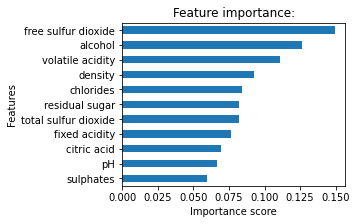

In [41]:
rf_model = clf_rf_best.fit(x_train_smt, y_train_smt)
plot_feature_importance(rf_model, data)

Umesto PCA algoritma, u kombinaciji sa Random Forestom iskorišćeno je rekurzivna eliminacija fičera (RFE).

In [42]:
def recursive_f_elimination(estimator, x_train, y_train, x_test):
    rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='accuracy')
    rfecv.fit(x_train, y_train)
    x_train = rfecv.transform(x_train)
    x_test = rfecv.transform(x_test)
    print("No. of best features: ", rfecv.n_features_)
    print("Selected features: ", rfecv.support_)
    return x_train, x_test

def run_rfe_clf(clf, x_train, y_train, x_test, y_test):
    # recursive elimination feature selection
    x_train_rfe, x_test_rfe = recursive_f_elimination(estimator=clf, x_train=x_train, 
                                                     y_train=y_train, x_test=x_test)
    #

    # fit and predict
    model = clf.fit(x_train_rfe, y_train)
    y_pred = clf.predict(x_test_rfe)
    
    # evaluate
    evaluate_model(clf, x_train_rfe, y_train, y_test, y_pred, True)

Ispostavlja se da se najbolji rezultati postižu kada su svi fičeri uključeni u kreiranje modela. 

No. of best features:  11
Selected features:  [ True  True  True  True  True  True  True  True  True  True  True]
Cross validation - Accuracy:
 0.9264451651248127
Accuracy:
 0.8122448979591836
Report:
               precision    recall  f1-score   support

           0       0.26      0.47      0.34        30
           1       0.69      0.77      0.72       227
           2       0.90      0.84      0.87       723

    accuracy                           0.81       980
   macro avg       0.62      0.69      0.64       980
weighted avg       0.83      0.81      0.82       980



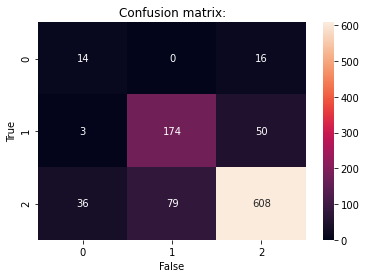

In [43]:
run_rfe_clf(clf_rf_best, x_train_smt, y_train_smt, x_test_out, y_test_out)

#### *Gradient boosting - RFE*
Potrebno je prvo pokrenuti gradient boosting algoritam sa balansiranim podacima ne bi li se odredila najbolja kombinacija hiperparametara koja će se koristiti za rekurzivnu eliminaciju fičera. Ispostavlja se da je balansiranje prouzrokovalo znatno lošije rezultate klasifikatora, te će se koristi pre pokušaja balansiranja.

In [44]:
run_clf(clf_gb, param_dict_gb, x_train_smt, x_test_out, y_train_smt, y_test_out, is_grid_search=True)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 64.3min finished


Best estimator:
 {'criterion': 'mse', 'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 250}
Best score:  0.9186113623443072
Cross validation - Accuracy:
 0.9167929867176599
Accuracy:
 0.5571428571428572
Report:
               precision    recall  f1-score   support

           0       0.10      0.60      0.17        30
           1       0.45      0.94      0.61       227
           2       0.94      0.44      0.60       723

    accuracy                           0.56       980
   macro avg       0.50      0.66      0.46       980
weighted avg       0.80      0.56      0.59       980

Confusion matrix:
 [[ 18   3   9]
 [  4 213  10]
 [155 253 315]]


In [48]:
clf_gb_best = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.3,
                                         max_depth=5, n_estimators=100)

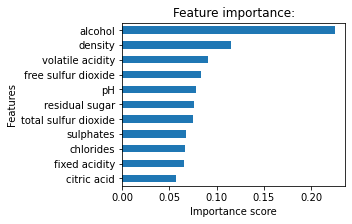

In [51]:
gb_model = clf_gb_best.fit(x_train_s, y_train)
plot_feature_importance(gb_model, data)

Gradient boosting je takođe zaključio da se najbolji rezultati dobijaju korišćenjem svih fičera.

No. of best features:  11
Selected features:  [ True  True  True  True  True  True  True  True  True  True  True]
Cross validation - Accuracy:
 0.8300124455912634
Accuracy:
 0.823469387755102
Report:
               precision    recall  f1-score   support

           0       0.48      0.37      0.42        30
           1       0.73      0.59      0.65       227
           2       0.85      0.92      0.88       723

    accuracy                           0.82       980
   macro avg       0.69      0.62      0.65       980
weighted avg       0.82      0.82      0.82       980



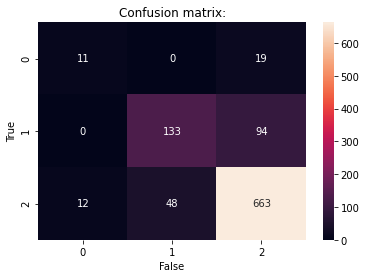

In [53]:
run_rfe_clf(clf_gb_best, x_train_s, y_train, x_test_s, y_test)

***Random Forest klasifikator se i dalje pokazuje kao najuspešniji.***

### ***Zaključak***
U ovom notebook-u demonstrirano je korišćenje većeg broja klasifikatora ne bi li se odredio kvalitet belog vina na osnovu određenih fizičko-hemijskih karakteristika. Glavni problemi predstavljali su nebalansiranost klasa, kao i velika količina outlier-a. Nekoliko različitih tehnika je pokušano u nadi da se dati problemi prevaziđu, odnosno da se klasifikatori poboljšaju. Ispostavilo se da najbolje rezultate daje Random Forest klasifikator, pri čemu i Gradient Boosting klasifikator daje relativno slične rezultate, međutim, i pored različitih predstavljanih tehnika nije su se postigli zadovoljavajući rezultati pri klasifikaciji manjinskih klasa.